In [1]:
import torch
import os, sys
import numpy as np
module_rootdir = '../../..'
dataset_rootdir = '../../../..'
label_rootdir = module_rootdir
weight_rootdir = module_rootdir
sys.path.append(module_rootdir)

from modules.first_stage.inference import inference
from modules.first_stage.set_parameters_for_inference import set_param_for_inference
from modules.plot.viz_annotation import vizualize_bbox_resized

In [2]:
weights_file = 'model_weights/1705990924432/anchor_free_detector.pt'

param_dict = set_param_for_inference(
    dataset_type = 'kitti',
    module_rootdir = module_rootdir,
    dataset_rootdir = dataset_rootdir,
    label_rootdir = label_rootdir,
    batch_size = 1,
    trained_weights_file = os.path.join(weight_rootdir, weights_file))

device = param_dict['device']
dataset_param = param_dict['dataset_param']
dataset_train = param_dict['dataset_train']
dataset_val = param_dict['dataset_val'] 
detector = param_dict['detector']

deltas_mean = torch.tensor(dataset_param.deltas_mean, dtype=torch.float32, device=device)
deltas_std = torch.tensor(dataset_param.deltas_std, dtype=torch.float32, device=device)
grid_coord = dataset_param.grid_coord.to(device)

GPU is available. Good to go!
printing model config parameters
----------------------------------------------------------------------------------------------------
backbone                        : efficientnet_b4
num_backbone_nodes              : 4
num_extra_blocks                : 1
num_levels                      : 5
extra_blocks_feat_dim           : 512
num_fpn_blocks                  : 2
fpn_feat_dim                    : 128
prediction head stem_channels   : [128, 128, 128, 128]
activation                      : swish
image dimension BDD (H, W, D)   : (360, 640, 3)
image dimension KITTI (H, W, D) : (263, 873, 3)
num_classes                     : 2
DEVICE                          : cuda
****************************************************************************************************
 
Loading JSON file .. please wait
Sequence: 0000
Sequence: 0001
Sequence: 0002
Sequence: 0003
Sequence: 0004
Sequence: 0005
Sequence: 0006
Sequence: 0008
Sequence: 0009
Sequence: 0011
Sequence: 0012

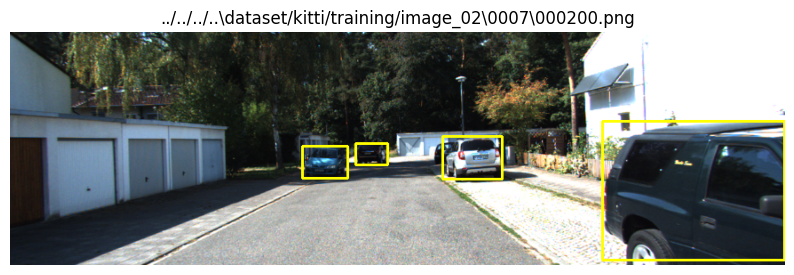

prediction scores in ascending order:
[0.8889311  0.9504727  0.95685345 0.95909894]
classification scores in ascending order:
[0.9998777  0.99988914 0.9999236  0.9999529 ]


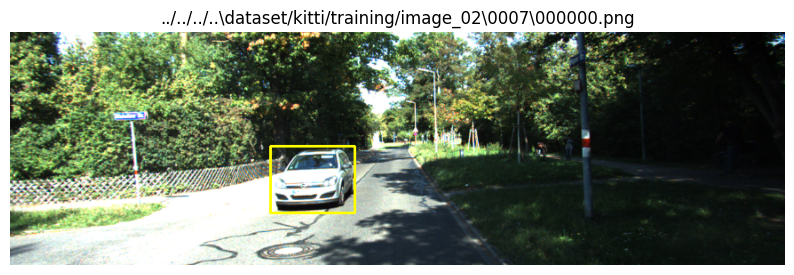

prediction scores in ascending order:
[0.9449239]
classification scores in ascending order:
[0.9999187]


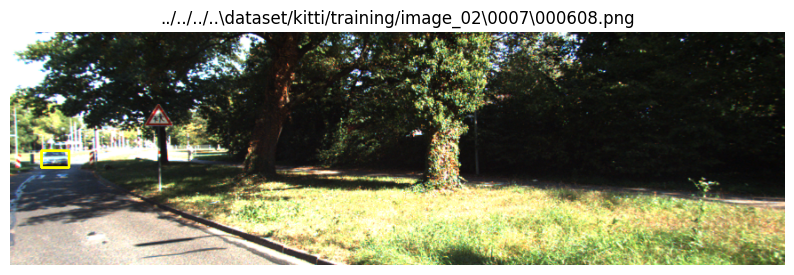

prediction scores in ascending order:
[0.76468474]
classification scores in ascending order:
[0.9999666]


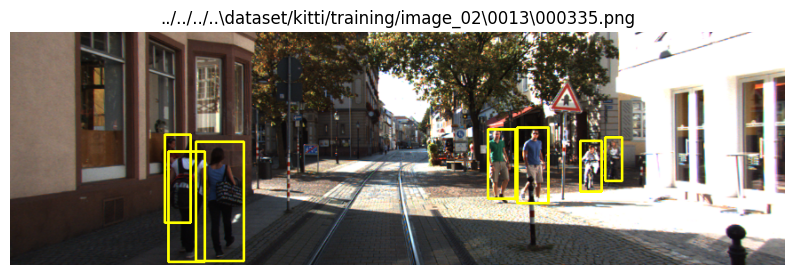

prediction scores in ascending order:
[0.58053464 0.59585667 0.6987543  0.84701693 0.9312925  0.94489413
 0.95124817]
classification scores in ascending order:
[0.9991573  0.99984634 0.9999523  0.99999094 0.99999225 0.9999938
 0.99999666]


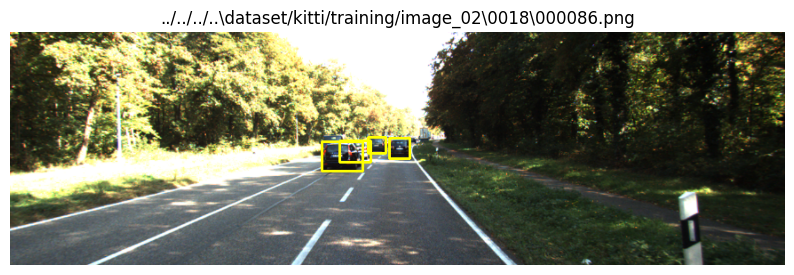

prediction scores in ascending order:
[0.71925086 0.88893497 0.94040865 0.9552695 ]
classification scores in ascending order:
[0.99987555 0.9999305  0.99995506 0.9999732 ]


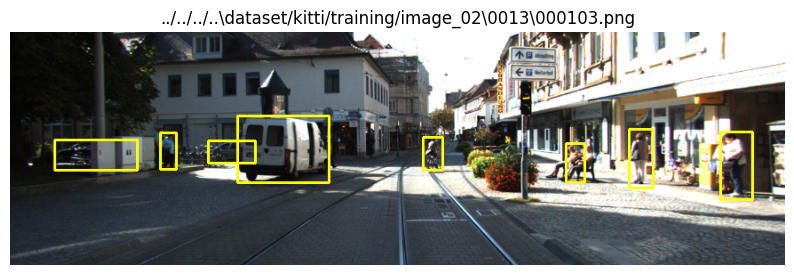

prediction scores in ascending order:
[0.7119891  0.7510179  0.7762813  0.83139735 0.8708592  0.87701076
 0.9400424  0.95987123]
classification scores in ascending order:
[0.9976139  0.99803704 0.99980384 0.9999515  0.9999763  0.99999595
 0.99999595 0.99999905]


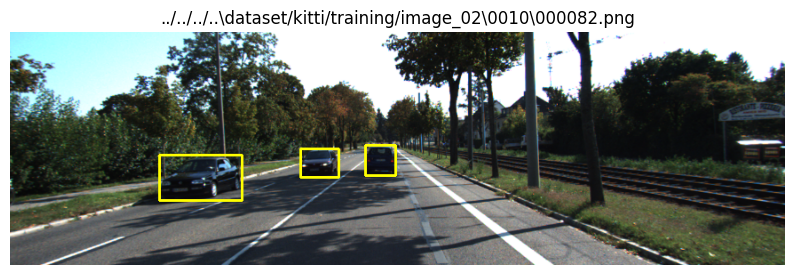

prediction scores in ascending order:
[0.95243955 0.95294255 0.9610266 ]
classification scores in ascending order:
[0.9998697  0.99991727 0.99995255]


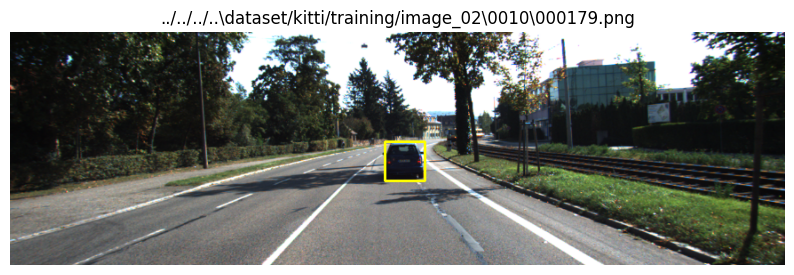

prediction scores in ascending order:
[0.94426084]
classification scores in ascending order:
[0.9999503]


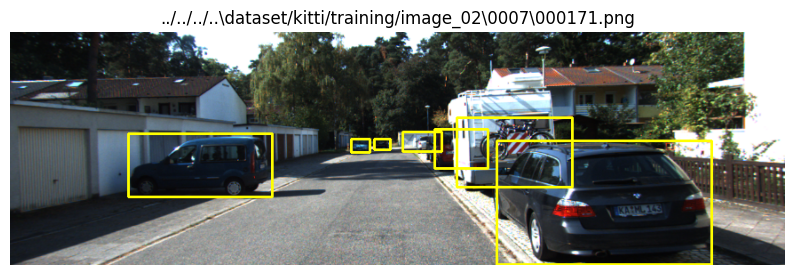

prediction scores in ascending order:
[0.68608177 0.7520712  0.7544418  0.887708   0.94703054 0.95009124
 0.9561712 ]
classification scores in ascending order:
[0.9992181  0.99982685 0.99987936 0.9998958  0.99992824 0.9999379
 0.999992  ]


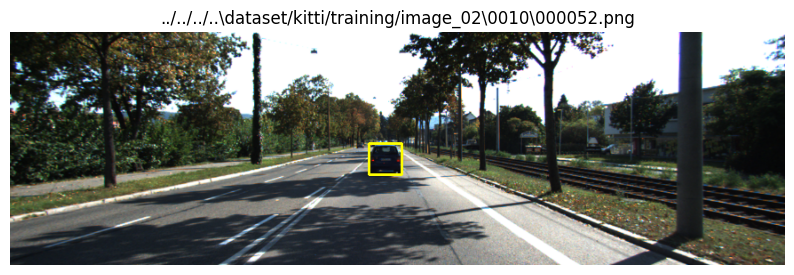

prediction scores in ascending order:
[0.96172005]
classification scores in ascending order:
[0.9998796]


In [4]:
# dataset = dataset_train
dataset = dataset_val
iter_start_offset = 0
max_iters = iter_start_offset + 10

nms_thresh = 0.35
score_threshold = torch.tensor([0.6, 0.5], dtype=torch.float32).to(device)

for iter in range(iter_start_offset, max_iters):

    img, labels = dataset.__getitem__(iter)
    img_path = labels['img_path']
    img = img.unsqueeze(0).to(device)
    bboxes = [labels['bbox'].to(device)]
    clslabels = [labels['obj_class_label'].to(device)]

    pred = inference(
        detector, img, grid_coord, 
        deltas_mean, deltas_std,
        score_threshold, nms_thresh)
    
    pred_score = pred['pred_score'].cpu().numpy()
    pred_class = pred['pred_class'].cpu().numpy()
    pred_box = pred['pred_box'].cpu().numpy()
    cls_prob = pred['cls_prob'].cpu().numpy()

    vizualize_bbox_resized(img_path, pred_box, dataset_param.IMG_RESIZED_W, dataset_param.IMG_RESIZED_H, 
                           thickness = 2, figsize=(10,8))
    print('prediction scores in ascending order:')
    print(np.sort(pred_score))
    print('classification scores in ascending order:')
    print(np.sort(cls_prob))
    print('=' * 100)